In [1]:
import pandas as pd

df = pd.read_csv("/content/breast_cancer_abstracts_FINAL.txt", sep="\t")

In [2]:
import re # regex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import layers
from keras.utils import plot_model


from sklearn.preprocessing import OneHotEncoder, LabelEncoder 
from sklearn.metrics import (
    accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef, 
    classification_report, precision_recall_fscore_support, 
    confusion_matrix, ConfusionMatrixDisplay
)

In [3]:
df.head()

,PMID,Abstract
0,37010907,1. J Particip Med. 2023 Apr 3;15:e42704. doi: ...
1,37008540,1. Asia Pac J Oncol Nurs. 2023 Feb 1;10(3):100...
2,37007104,1. Front Oncol. 2023 Mar 17;13:1144021. doi: 1...
3,37002189,1. Jpn J Clin Oncol. 2023 Mar 31:hyad026. doi:...
4,37000800,1. PLoS One. 2023 Mar 31;18(3):e0283849. doi: ...


In [5]:
import nltk.data
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
print(tokenizer.tokenize(df["Abstract"][0]))

['1.', 'J Particip Med.', '2023 Apr 3;15:e42704.', 'doi: 10.2196/42704.', 'Acceptability of Automated Robotic Clinical Breast Examination: Survey Study.', 'Jenkinson GP(#)(1), Houghton N(#)(2), van Zalk N(3), Waller J(4), Bello F(2), \nTzemanaki A(1).', 'Author information:\n(1)Bristol Robotics Laboratory, Department of Mechanical Engineering, University \nof Bristol, Bristol, United Kingdom.', '(2)Centre for Engagement and Simulation Science, Department of Surgery and \nCancer, Imperial College London, London, United Kingdom.', '(3)Dyson School of Design Engineering, Imperial College London, London, United \nKingdom.', "(4)Cancer Prevention Group, School of Cancer & Pharmaceutical Sciences, King's \nCollege London, London, United Kingdom.", '(#)Contributed equally\n\nBACKGROUND: In the United Kingdom, women aged 50 to 70 years are invited to \nundergo mammography.', 'However, 10% of invasive breast cancers occur in women aged \n≤45 years, representing an unmet need for young women.', 

Clearly, there are rogue "\n"s  in the data.

In [7]:
lines = tokenizer.tokenize(df["Abstract"][0])

In [8]:
lines

['1.',
 'J Particip Med.',
 '2023 Apr 3;15:e42704.',
 'doi: 10.2196/42704.',
 'Acceptability of Automated Robotic Clinical Breast Examination: Survey Study.',
 'Jenkinson GP(#)(1), Houghton N(#)(2), van Zalk N(3), Waller J(4), Bello F(2), \nTzemanaki A(1).',
 'Author information:\n(1)Bristol Robotics Laboratory, Department of Mechanical Engineering, University \nof Bristol, Bristol, United Kingdom.',
 '(2)Centre for Engagement and Simulation Science, Department of Surgery and \nCancer, Imperial College London, London, United Kingdom.',
 '(3)Dyson School of Design Engineering, Imperial College London, London, United \nKingdom.',
 "(4)Cancer Prevention Group, School of Cancer & Pharmaceutical Sciences, King's \nCollege London, London, United Kingdom.",
 '(#)Contributed equally\n\nBACKGROUND: In the United Kingdom, women aged 50 to 70 years are invited to \nundergo mammography.',
 'However, 10% of invasive breast cancers occur in women aged \n≤45 years, representing an unmet need for youn

In [9]:
# lines_not_sentences = str(df["Abstract"][0]).splitlines()
lines = str(df["Abstract"][0]).splitlines()

In [11]:
TARGET_LABELS = ["OBJECTIVE:", "BACKGROUND:", "METHODS:", "RESULTS:", "CONCLUSIONS:"]

In [12]:
NULL_WORDS = ["Copyright", "Published by", "All rights reserved", "copyright", "©", "The Author(s)",
              "For permissions,"]

In [31]:
# converting unstructured data into a structured format

def get_dict_from_text(df):

  line_data = {}
  first = 0
  last = 0

  abstract_samples = []

  for i, abstract in enumerate(df["Abstract"]):

    # get sentences
    lines = tokenizer.tokenize(abstract)

    for l_no, l in enumerate(lines):
      lines[l_no] = lines[l_no].replace("\n", " ") # removing random \n values found in every abstract.
     
      if any(word in l for word in TARGET_LABELS): # find "BACKGROUND", "METHODS", etc in sentence

        if l.startswith(tuple(TARGET_LABELS)):
          target = l.split()[0] # extract target if sentence starts with any target label
          
        else:
          target_loc = [k for k,w in enumerate(l.split()) if w in TARGET_LABELS] # find the position of the word with the target label

          try:
            target = l.split()[target_loc[0]]

          except:
            print("error in: ", l) # Abstracts with "BACKGROUND/METHODS" -> we do not consider them
        
        first = l_no # where sentence starts

        for j in range(first+1, len(lines)):

          if any(word in lines[j] for word in TARGET_LABELS):

            last = j # find next instance of keyword
            break

          elif any(null_word in lines[j] for null_word in NULL_WORDS) or (j == len(lines)-1): 
            last = j-1 # removing words like "copyright" etc found after the conclusion
            break

          else:
            last = j # last word in the sentence
            break
        
        for j in range(first, last):
          line_data["abstract_id"] = df["PMID"][i] 
          line_data["line_id"] = f'{df["PMID"][i]}_{first}_{len(lines)}' # unique line id
          
          if lines[j].startswith(tuple(TARGET_LABELS)):
            
            # Removing target variable from the original string

            words = lines[j].split()[1:]
            sents = " ".join(words)
            line_data["abstract_text"] = sents.replace("\n", "")

          elif any(word in l for word in TARGET_LABELS):
            words = lines[j].split()
            result = [k for k,w in enumerate(words) if w in TARGET_LABELS] # find position of result
            # print(result)
            try:
              sents = " ".join(words[result[0]+1:])
              line_data["abstract_text"] = sents.replace("\n", "")
            except:
              print("error 2 in: ", lines[j])

          else:
              line_data["abstract_text"] = lines[j].replace("\n", "")

          line_data["line_number"] = j
          line_data["total_lines"] = len(lines) # total num of lines (may need to change?)
          # line_data["current_line"]
          line_data["current_line"] = f'{first}_{len(lines)}'

          line_data["target"] = target

          dictionary = dict(line_data).copy()
          abstract_samples.append(dictionary)

  return abstract_samples

In [32]:
# train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))]) #80/10/10
train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))]) #60/20/20

In [33]:
train_df.shape, val_df.shape, test_df.shape

((5641, 2), (1880, 2), (1881, 2))

In [34]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [35]:
train_df.head()

,PMID,Abstract
0,21055153,1. Zhonghua Bing Li Xue Za Zhi. 2010 Jun;39(6)...
1,35594581,1. Comput Methods Programs Biomed. 2022 Jun;22...
2,8487323,1. J Natl Cancer Inst. 1993 May 19;85(10):785-...
3,29554468,1. Med Decis Making. 2018 Apr;38(1_suppl):140S...
4,30656783,1. Psychooncology. 2019 Mar;28(3):600-606. doi...


In [36]:
train_samples = get_dict_from_text(train_df)
val_samples = get_dict_from_text(val_df)
test_samples = get_dict_from_text(test_df)

error in:  BACKGROUND/OBJECTIVE: This study aimed to analyse the local recurrence (LR) and 
breast cancer related mortality (BCRM) in older women who underwent 
breast-conserving surgery (BCS) with and without adjuvant radiotherapy (XRT).
error 2 in:  BACKGROUND/OBJECTIVE: This study aimed to analyse the local recurrence (LR) and  breast cancer related mortality (BCRM) in older women who underwent  breast-conserving surgery (BCS) with and without adjuvant radiotherapy (XRT).
error in:  In addition, there was no significant difference between groups (p= 
0.386)CONCLUSIONS: P followed by FEC75 with concurrent trastuzumab could provide 
enough evidence of cardiac safety.
error in:  INTERVENTIONS/METHODS: Consented participants were randomized 2:1 to hypnosis or 
PMR.
error 2 in:  INTERVENTIONS/METHODS: Consented participants were randomized 2:1 to hypnosis or  PMR.
error in:  PURPOSE/OBJECTIVE: Lymphedema after breast cancer treatment can be an 
irreversible condition with a negative impa

In [37]:
train_samples[:2]

[{'abstract_id': 21055153,
  'line_id': '21055153_6_18',
  'abstract_text': '(1) To investigate the promoter methylation status of gene p16(INK4a) and gene RB in breast carcinoma and the adjacent non-neoplastic hyperplastic epithelial tissue.',
  'line_number': 6,
  'total_lines': 18,
  'current_line': '6_18',
  'target': 'OBJECTIVE:'},
 {'abstract_id': 21055153,
  'line_id': '21055153_8_18',
  'abstract_text': 'Methylation status of promoters of p16(INK4a) gene and RB gene was detected by using methylation specific PCR in 46 cases of breast cancer, 22 cases of the adjacent non-neoplastic hyperplastic epithelium tissue and 7 cases of normal breast tissue.',
  'line_number': 8,
  'total_lines': 18,
  'current_line': '8_18',
  'target': 'METHODS:'}]

To ensure that pmids are separate in train, dev, and test we split from the original df

In [38]:
# back to df but now with appropriate cols
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [39]:
train_df.head(10)

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,21055153,21055153_6_18,(1) To investigate the promoter methylation st...,6,18,6_18,OBJECTIVE:
1,21055153,21055153_8_18,Methylation status of promoters of p16(INK4a) ...,8,18,8_18,METHODS:
2,21055153,21055153_10_18,The methylation rate of p16(INK4a) gene was 23...,10,18,10_18,RESULTS:
3,21055153,21055153_15_18,The abnormal methylation of p16(INK4a) gene ma...,15,18,15_18,CONCLUSIONS:
4,35594581,35594581_24_41,Breast density assessed from digital mammogram...,24,41,24_41,OBJECTIVE:
5,35594581,35594581_32_41,A multi-center study composed of 1395 women wh...,32,41,32_41,METHODS:
6,35594581,35594581_34_41,The combination of five networks implementing ...,34,41,34_41,RESULTS:
7,35594581,35594581_36_41,The proposed methodology has a similar perform...,36,41,36_41,CONCLUSIONS:
8,8487323,8487323_8_22,Studies in animals and geographic correlations...,8,22,8_22,BACKGROUND:
9,8487323,8487323_12_22,Aspirates of subcutaneous fat from the buttock...,12,22,12_22,METHODS:


In [40]:
train_df.target.value_counts()

RESULTS:        5300
METHODS:        5172
OBJECTIVE:      3891
CONCLUSIONS:    3762
BACKGROUND:     1767
Name: target, dtype: int64

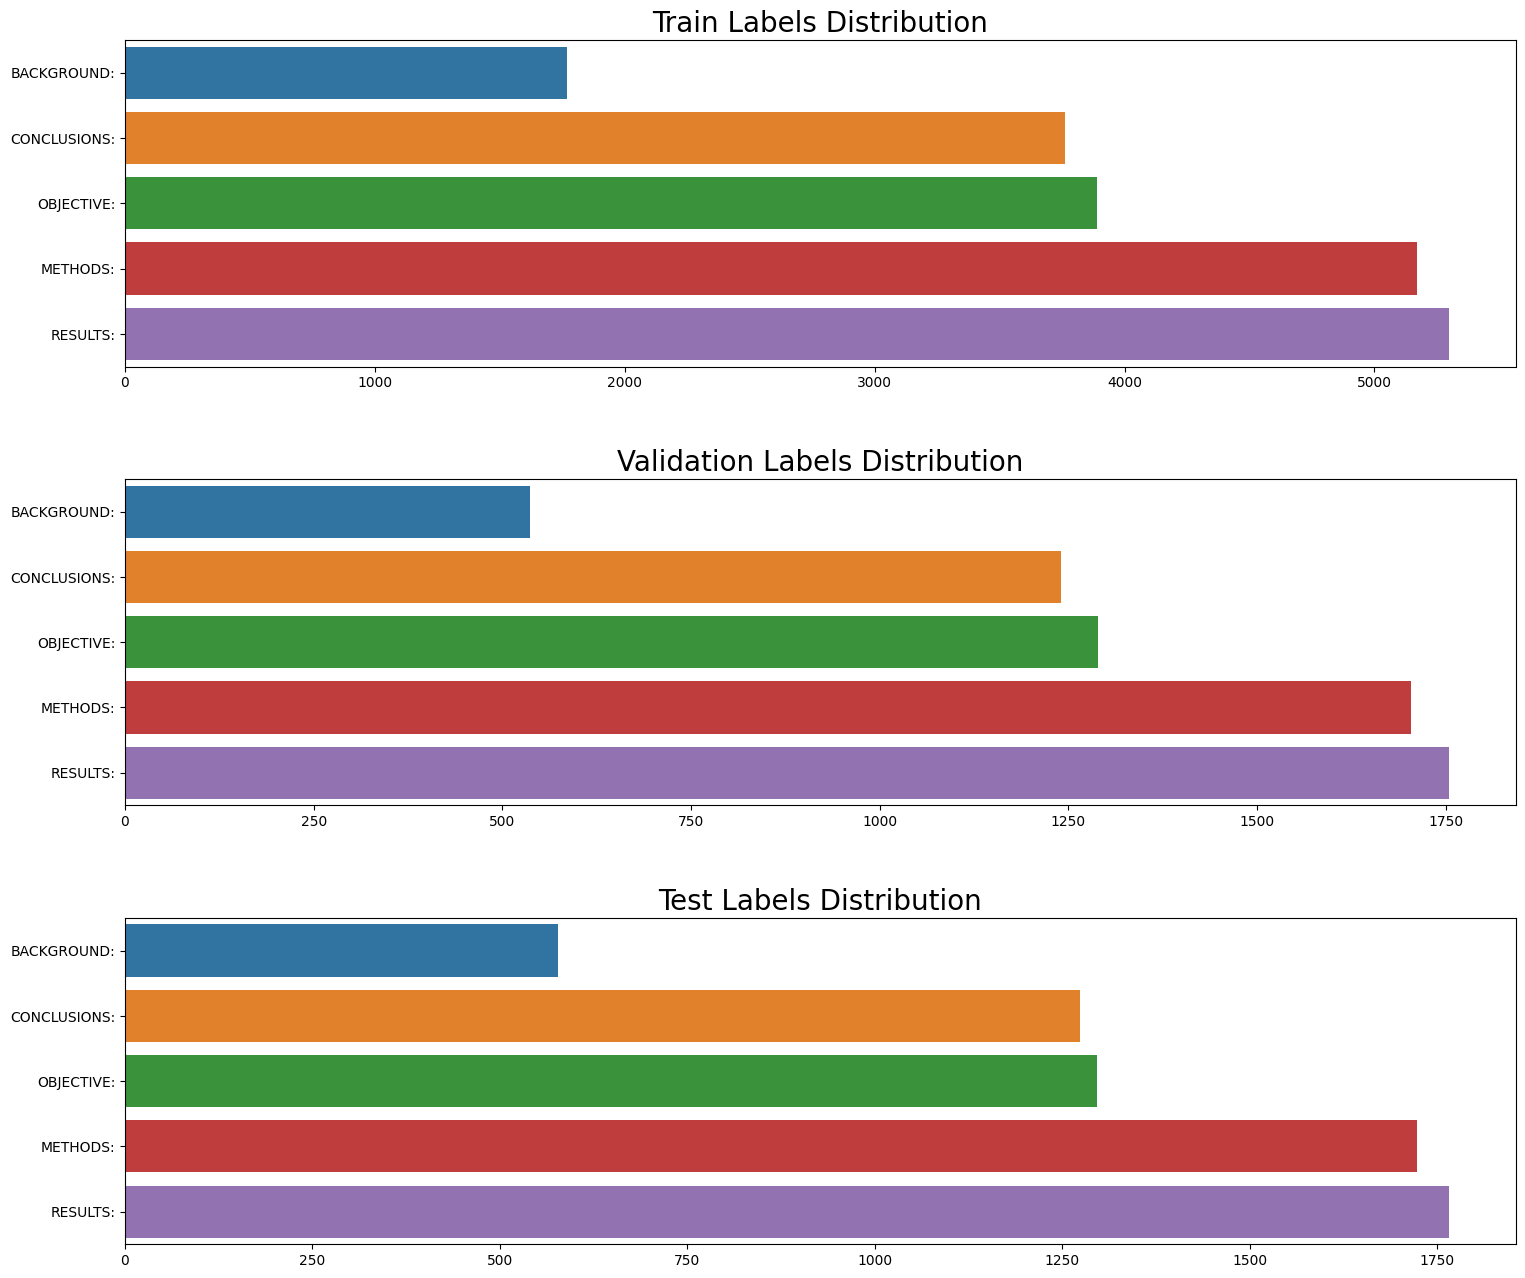

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 14))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=20)
train_distribution = train_df['target'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h",
            ax=ax1)

# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=20)
val_distribution = val_df['target'].value_counts().sort_values()
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h",
            ax=ax2);

# Plot Test Labels Distribution
ax3.set_title('Test Labels Distribution', fontsize=20)
test_distribution = test_df['target'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient="h",
            ax=ax3);

In [42]:
# Convert abstract text lines into lists
train_sentences = train_df["abstract_text"].tolist()
val_sentences = val_df["abstract_text"].tolist()
test_sentences = test_df["abstract_text"].tolist()

In [43]:
train_sentences_count = len(train_sentences)
val_sentences_count = len(val_sentences)
test_sentences_count = len(test_sentences)
total_sentences_count = train_sentences_count + val_sentences_count + test_sentences_count

print(f'Train samples count:\t\t{train_sentences_count}')
print(f'Dev/Validation sample count:\t{val_sentences_count}')
print(f'Test sample count:\t\t{test_sentences_count}')
print(f'Total samples:\t\t\t{total_sentences_count}')

Train samples count:		19892
Dev/Validation sample count:	6526
Test sample count:		6637
Total samples:			33055


In [44]:
one_hot_encoder = OneHotEncoder(sparse_output=False)

In [45]:
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [46]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [47]:
label_encoder = LabelEncoder()

In [48]:
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# inspect label encoded targets
train_labels_encoded

array([3, 2, 4, ..., 3, 2, 4])

In [49]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 5
Classes: ['BACKGROUND:' 'CONCLUSIONS:' 'METHODS:' 'OBJECTIVE:' 'RESULTS:']


In [50]:
line_one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="infrequent_if_exist")

In [51]:
train_lines_encoded = line_one_hot_encoder.fit_transform(train_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
val_lines_encoded = line_one_hot_encoder.transform(val_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
test_lines_encoded = line_one_hot_encoder.transform(test_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)

In [52]:
test_lines_encoded.shape

(6637, 860)

In [53]:
def apply_smoothing(line_one_hot, esp=0.01):
    return np.abs(line_one_hot - esp)

def revert_smoothing(line_one_hot_smooth, esp=0.01):
    unsmooth = line_one_hot_smooth
    
    unsmooth[unsmooth>esp] = 1.0
    unsmooth[unsmooth<=esp] = 0.0
    
    return unsmooth

In [54]:
# Only apply smoothing to train lines feature 
train_lines_encoded = apply_smoothing(train_lines_encoded)

In [55]:
def create_pipeline(features, labels, batch_size=32, shuffle=False, cache=False, prefetch=False) -> tf.data.Dataset:
    '''
    Generates an input pipeline using the tf.data API for training and inference.
    
    @params
        - features: (tuple) -> tuple containing the feature data 
        - labels: (tf.Tensor | np.ndarray, default=None) -> target data related to the feature data
        - batch_size: (int) -> size for batched (default=32) 
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (bool) -> condition for caching data, data is cached in memory when True (default=False)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)
        
    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''
    
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Create dataset with features and labels
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    
    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    # Apply batching
    ds = ds.batch(batch_size)
    
    # Apply caching based on condition
    # Note: Do this if the data is small enough to fit in memory!!!
    if cache:
        ds = ds.cache(buffer_size=AUTOTUNE)
    
    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    # Return the dataset
    return ds

In [56]:
BATCH_SIZE = 32

# Create preprocessed training dataset
train_features = (train_sentences, train_lines_encoded.astype(np.float32)) 
train_labels = train_labels_one_hot.astype(np.float32)

# Create preprocessed train input data pipeline
train_ds = create_pipeline(
    train_features, train_labels, 
    batch_size=BATCH_SIZE, shuffle=True, 
    cache=False, prefetch=True)

In [57]:
# Create preprocessed validation dataset
val_features = (val_sentences, val_lines_encoded.astype(np.float32)) 
val_labels = val_labels_one_hot.astype(np.float32)

# Create preprocessed validation input data pipeline
val_ds = create_pipeline(val_features, val_labels, 
                         batch_size=BATCH_SIZE, shuffle=False, 
                         cache=False, prefetch=True)

In [58]:
# Create preprocessed test dataset
test_features = (test_sentences, test_lines_encoded.astype(np.float32)) 
test_labels = test_labels_one_hot.astype(np.float32)

# Create preprocessed test input data pipeline
test_ds = create_pipeline(test_features, test_labels, 
                          batch_size=BATCH_SIZE, shuffle=False, 
                          cache=False, prefetch=True)

In [59]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 860), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 860), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Test Input Data Pipeline:

 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 860), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


In [60]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 53.2 MB/s eta 0:00:00


In [61]:
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

# Modelling

CHANGE ENCODER

In [62]:
encoder_link = 'https://tfhub.dev/google/universal-sentence-encoder/4'
encoder_name = 'universal_sentence_encoder'
encoder_trainable=False # set trainable to False for inference-only  # TRY TRAINABLE = TRUE

encoder = get_tfhub_model(encoder_link, encoder_name, model_trainable=encoder_trainable)

In [63]:
class SelfAttentionBlock(layers.Layer):
    
    def __init__(self, units: int, activation='gelu', kernel_initializer='GlorotNormal', **kwargs):
        super(SelfAttentionBlock, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.kernel_initializer = tf.keras.initializers.deserialize(kernel_initializer)
        
        self.query = layers.LSTM(self.units, activation=self.activation, 
                                 kernel_initializer=self.kernel_initializer, 
                                 return_sequences=True, name=f'block_query_lstm')
        
        self.value = layers.LSTM(self.units, activation=self.activation, 
                                 kernel_initializer=self.kernel_initializer, go_backwards=True, 
                                 return_sequences=True, name=f'block_value_lstm')
        
        self.attention = layers.AdditiveAttention(name='block_attention')
        self.average_pooler = layers.GlobalAveragePooling1D(name='block_average_pooler')
        self.query_batch_norm = layers.BatchNormalization(name='block_query_batch_norm')
        self.attention_batch_norm = layers.BatchNormalization(name='block_attention_batch_norm')
        self.residual = layers.Add(name='block_residual')
        
        
    def __call__(self, x):
        # Expand dimensions for LSTMs
        dim_expand_layer = layers.Lambda(lambda embedding: tf.expand_dims(embedding, axis=1), name='block_dim_expand')
        x_expanded = dim_expand_layer(x)
        
        # Generate LSTM sequences
        block_query = self.query(x_expanded)
        block_value = self.value(x_expanded)
        
        # Apply self-attention to LSTM 
        block_attention = self.attention([block_query, block_value])
        
        # Apply GlobalAvgPooling and BatchNorm to ensure output shape is 1D 
        block_query_pooling = self.average_pooler(block_query)
        block_query_batch_norm = self.query_batch_norm(block_query_pooling)
        
        block_attention_pooling = self.average_pooler(block_attention)
        block_attention_batch_norm = self.attention_batch_norm(block_attention_pooling)
        
        # Generate addition residual with processed query and attention
        block_residual = self.residual([block_query_batch_norm, block_attention_batch_norm])
        
        return block_residual

In [64]:
def build_model():
    # Model Inputs
    #------------
    abstract_input = layers.Input(shape=[], dtype=tf.string, name='abstract_text_input')    
    abstract_current_line = layers.Input(shape=(860), dtype=tf.float32, name='abstract_current_line')
    
    # Define Layer Initializer
    #------------
    initializer = tf.keras.initializers.GlorotNormal()

    # Text Embedding
    #------------
    abstract_embedding = encoder(abstract_input)
    
    # Self Attention Block Stream
    #------------
    add_attention_block = SelfAttentionBlock(64)(abstract_embedding)
    abstract_dense = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(abstract_embedding)
    attention_residual = layers.Multiply(name='mul_residual')([add_attention_block, abstract_dense])
    
    # Current Line Stream
    #------------
    current_line_dense = layers.Dense(32, activation='gelu', kernel_initializer=initializer)(abstract_current_line)
    current_line_dense = layers.Dropout(0.2)(current_line_dense)

    # Concat Streams
    #------------
    streams_concat = layers.Concatenate()([
        attention_residual,
        current_line_dense
    ])

    # Output Layer
    #------------
    output_layer = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(streams_concat)
    output_layer = layers.Dense(5, activation='softmax', kernel_initializer=initializer)(output_layer)

    return tf.keras.Model(inputs=[abstract_input, 
                                  abstract_current_line], 
                          outputs=[output_layer], name="use_attention_model")

In [65]:
model = build_model()

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [66]:
# View summary of model
model.summary()

Model: "use_attention_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 abstract_text_input (InputLaye  [(None,)]           0           []                               
 r)                                                                                               
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['abstract_text_input[0][0]']    
 rasLayer)                                                                                        
                                                                                                  
 block_dim_expand (Lambda)      (None, 1, 512)       0           ['universal_sentence_encoder[0][0
                                                                 ]']            

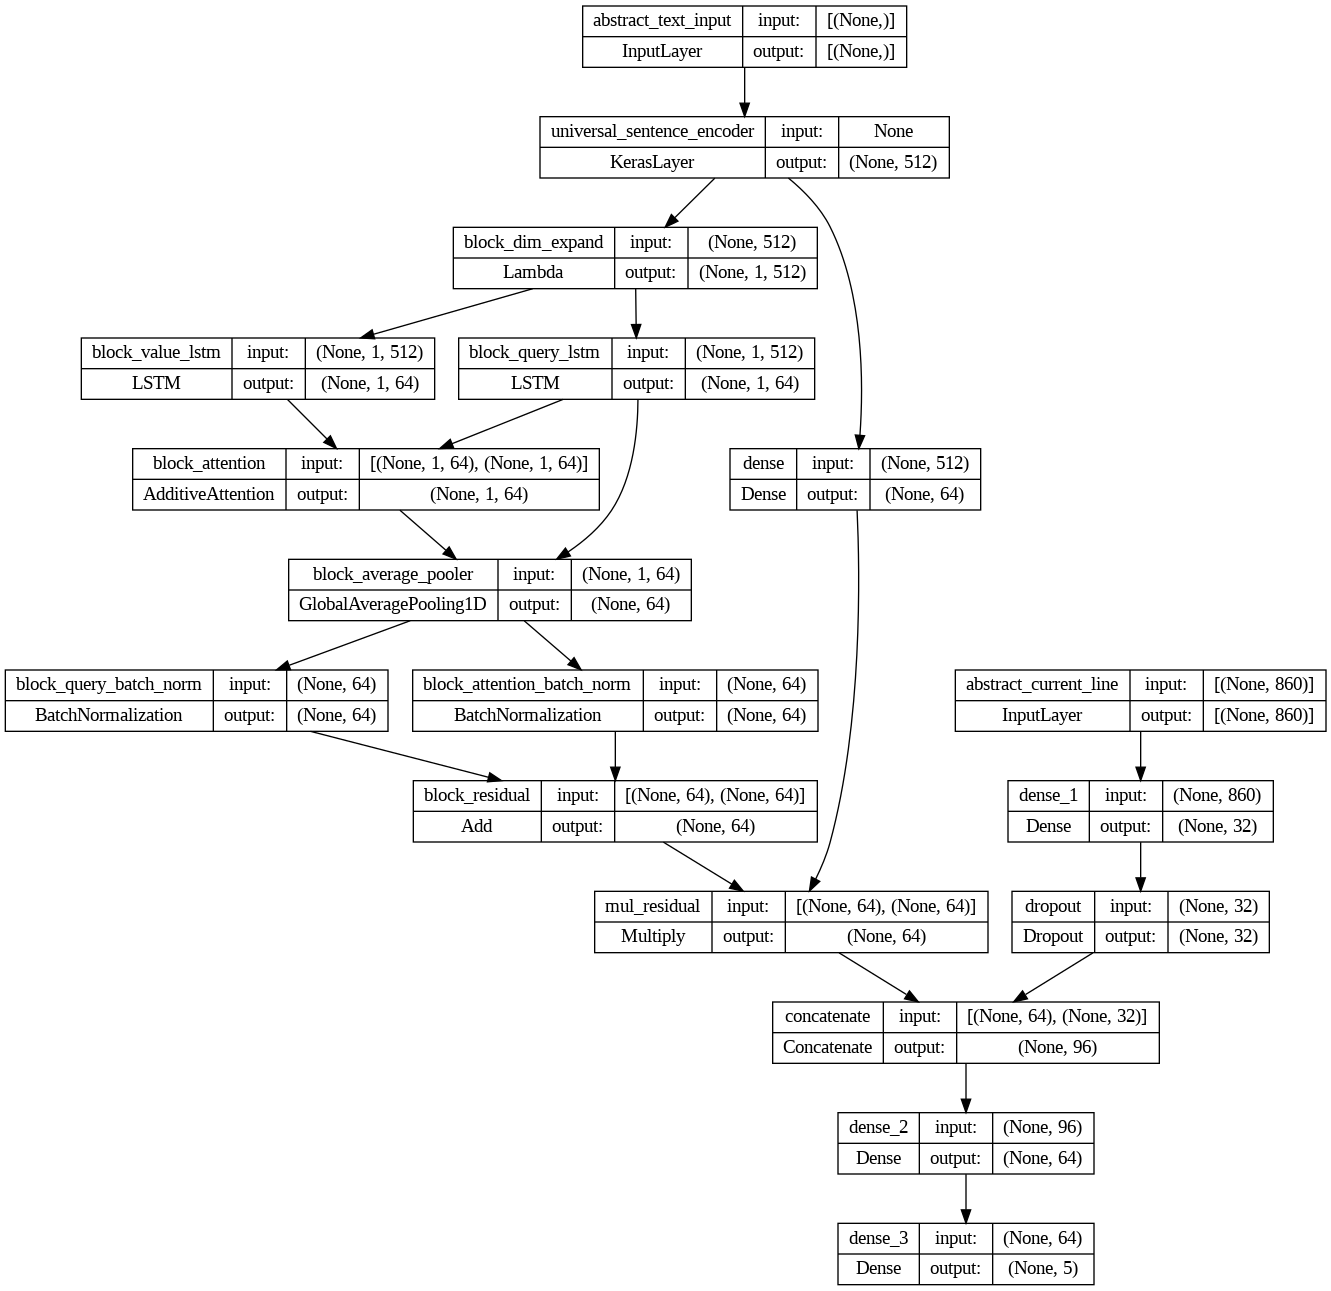

In [67]:
# Explore model visually
plot_model(
    model,
    show_shapes=True,
    expand_nested=True
)

In [68]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False):
    '''
        Trains a TensorFlow model and returns a dict object containing the model metrics history data. 
        
        @params
        - model: (tf.keras.model) -> model to be trained 
        - num_epochs: (int) -> number of epochs to train the model
        - callbacks_list: (list) -> list containing callback fuctions for model
        - tf_train_data: (tf.data.Dataset) -> dataset for model to be train on 
        - tf_valid_data: (tf.data.Dataset) -> dataset for model to be validated on (default=None)
        - shuffling: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        
        @returns
        - model_history: (dict) -> dictionary containing loss and metrics values tracked during training
    '''
    
    model_history = {}
    
    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
        
    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

In [69]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

EPOCHS = 20
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

In [70]:
train_sentences_count = len(train_sentences)
val_sentences_count = len(val_sentences)
test_sentences_count = len(test_sentences)
total_sentences_count = train_sentences_count + val_sentences_count + test_sentences_count

In [71]:
tf.random.set_seed(42)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=METRICS
)

print(f'Training {model.name}.')
print(f'Train on {train_sentences_count} samples, validate on {val_sentences_count} samples.')
print('----------------------------------')

model_history = train_model(
    model, EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False
)

Training use_attention_model.
Train on 19892 samples, validate on 6526 samples.
----------------------------------
Epoch 1/20
622/622 [==============================] - 35s 36ms/step - loss: 1.3601 - accuracy: 0.4740 - val_loss: 1.1542 - val_accuracy: 0.6571 - lr: 1.0000e-04
Epoch 2/20
622/622 [==============================] - 13s 20ms/step - loss: 1.0231 - accuracy: 0.6794 - val_loss: 0.9959 - val_accuracy: 0.6974 - lr: 1.0000e-04
Epoch 3/20
622/622 [==============================] - 13s 20ms/step - loss: 0.9547 - accuracy: 0.7133 - val_loss: 0.9518 - val_accuracy: 0.7225 - lr: 1.0000e-04
Epoch 4/20
622/622 [==============================] - 12s 20ms/step - loss: 0.8922 - accuracy: 0.7486 - val_loss: 0.9062 - val_accuracy: 0.7544 - lr: 1.0000e-04
Epoch 5/20
622/622 [==============================] - 15s 23ms/step - loss: 0.8307 - accuracy: 0.7829 - val_loss: 0.8647 - val_accuracy: 0.7792 - lr: 1.0000e-04
Epoch 6/20
622/622 [==============================] - 15s 23ms/step - loss: 0.78

In [72]:
# evaluate the model on the test data to see how it performs
model.evaluate(test_ds)

208/208 [==============================] - 2s 11ms/step - loss: 0.7355 - accuracy: 0.8352


[0.735525906085968, 0.8351665139198303]

In [73]:
# generate validation probabilities
val_probabilities = model.predict(val_ds, verbose=1)
val_probabilities

204/204 [==============================] - 3s 11ms/step


array([[0.49211556, 0.02552699, 0.01561396, 0.45917296, 0.00757051],
       [0.00583618, 0.0054874 , 0.94739634, 0.00947747, 0.03180264],
       [0.02751394, 0.7536884 , 0.01178009, 0.02953646, 0.17748117],
       ...,
       [0.01749298, 0.01286938, 0.9486298 , 0.00908065, 0.0119272 ],
       [0.06795315, 0.10832931, 0.16100015, 0.08039553, 0.5823218 ],
       [0.05085798, 0.3870443 , 0.29087746, 0.02605916, 0.24516103]],
      dtype=float32)

In [74]:
# generate test probabilities
test_probabilities = model.predict(test_ds, verbose=1)
test_probabilities

208/208 [==============================] - 2s 10ms/step


array([[0.59093434, 0.14056039, 0.01640695, 0.18651336, 0.06558496],
       [0.07187527, 0.03082657, 0.7612055 , 0.06574158, 0.070351  ],
       [0.12829171, 0.07030303, 0.04818505, 0.07932606, 0.67389417],
       ...,
       [0.03940928, 0.02302763, 0.8662787 , 0.03615306, 0.03513131],
       [0.04161273, 0.04235056, 0.02447489, 0.02386901, 0.8676928 ],
       [0.01320789, 0.9765322 , 0.00275154, 0.00368658, 0.00382193]],
      dtype=float32)

In [75]:
# generate test predictions with argmax
test_predictions = tf.argmax(test_probabilities, axis=1)
test_predictions

<tf.Tensor: shape=(6637,), dtype=int64, numpy=array([0, 2, 4, ..., 2, 4, 1])>

In [76]:
def plot_training_curves(history):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss')
    ax1.plot(epochs, val_loss, label='val_loss')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy')
    ax2.plot(epochs, val_accuracy, label='val_accuracy')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.legend();
    plt.tight_layout()

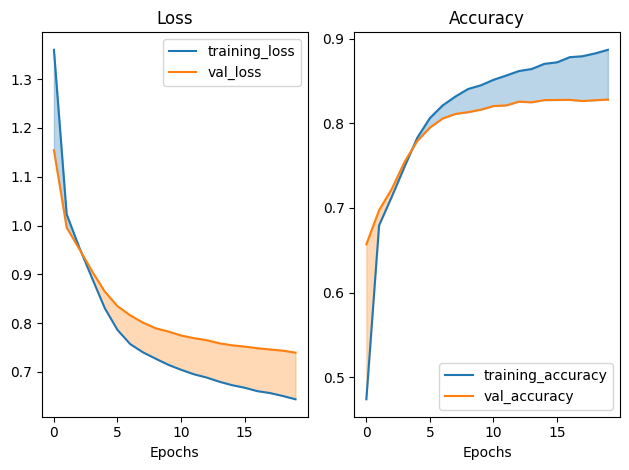

In [77]:
# plot model training history 
plot_training_curves(model_history)

In [78]:
# generate validation predictions with argmax
val_predictions = tf.argmax(val_probabilities, axis=1)
val_predictions

<tf.Tensor: shape=(6526,), dtype=int64, numpy=array([0, 2, 1, ..., 2, 4, 1])>

In [79]:
# Generate validation classification report
print(classification_report(val_labels_encoded, val_predictions, target_names=class_names))

              precision    recall  f1-score   support

 BACKGROUND:       0.52      0.69      0.59       537
CONCLUSIONS:       0.89      0.93      0.91      1241
    METHODS:       0.87      0.87      0.87      1704
  OBJECTIVE:       0.80      0.73      0.77      1289
    RESULTS:       0.89      0.83      0.86      1755

    accuracy                           0.83      6526
   macro avg       0.79      0.81      0.80      6526
weighted avg       0.84      0.83      0.83      6526



In [80]:
test_probabilities = model.predict(test_ds, verbose=1)
test_probabilities

208/208 [==============================] - 2s 10ms/step


array([[0.59093434, 0.14056039, 0.01640695, 0.18651336, 0.06558496],
       [0.07187527, 0.03082657, 0.7612055 , 0.06574158, 0.070351  ],
       [0.12829171, 0.07030303, 0.04818505, 0.07932606, 0.67389417],
       ...,
       [0.03940928, 0.02302763, 0.8662787 , 0.03615306, 0.03513131],
       [0.04161273, 0.04235056, 0.02447489, 0.02386901, 0.8676928 ],
       [0.01320789, 0.9765322 , 0.00275154, 0.00368658, 0.00382193]],
      dtype=float32)

In [81]:
# generate test predictions with argmax
test_predictions = tf.argmax(test_probabilities, axis=1)
test_predictions

<tf.Tensor: shape=(6637,), dtype=int64, numpy=array([0, 2, 4, ..., 2, 4, 1])>

In [82]:
print(classification_report(test_labels_encoded, test_predictions, target_names=class_names))

              precision    recall  f1-score   support

 BACKGROUND:       0.54      0.65      0.59       578
CONCLUSIONS:       0.90      0.95      0.92      1274
    METHODS:       0.87      0.88      0.87      1723
  OBJECTIVE:       0.79      0.75      0.77      1296
    RESULTS:       0.89      0.84      0.86      1766

    accuracy                           0.84      6637
   macro avg       0.80      0.81      0.81      6637
weighted avg       0.84      0.84      0.84      6637



In [83]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = round(accuracy_score(y_true, y_pred), 5)
    top_3_accuracy = round(top_k_accuracy_score(y_true, y_probabilities, k=3), 5)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(test_labels_encoded, 
                                                                                 test_predictions, 
                                                                                 average="weighted")
    model_precision, model_recall, model_f1 = round(model_precision, 5), round(model_recall, 5), round(model_f1, 5)
    model_matthews_corrcoef = round(matthews_corrcoef(y_true, y_pred), 5)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy}\n')
    print('_____________________________________________')
    print(f'top_3_accuracy_score:\t{top_3_accuracy}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef}\n')
    print('=============================================')
    
    return

In [84]:
generate_preformance_scores(val_labels_encoded, val_predictions, val_probabilities)


Performance Metrics:

accuracy_score:		0.82807

_____________________________________________
top_3_accuracy_score:	0.98682

_____________________________________________
precision_score:	0.83996

_____________________________________________
recall_score:		0.83517

_____________________________________________
f1_score:		0.83672

_____________________________________________
matthews_corrcoef:	0.78072



In [85]:
generate_preformance_scores(test_labels_encoded, test_predictions, test_probabilities)


Performance Metrics:

accuracy_score:		0.83517

_____________________________________________
top_3_accuracy_score:	0.98644

_____________________________________________
precision_score:	0.83996

_____________________________________________
recall_score:		0.83517

_____________________________________________
f1_score:		0.83672

_____________________________________________
matthews_corrcoef:	0.78966



In [86]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=11): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True,
        fmt='d',
        linewidths=1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix')
    disp.set_xlabel('Predicted Label') 
    disp.set_ylabel('True Label')
    
    # Plot confusion matrix
    plt.show()
    
    return

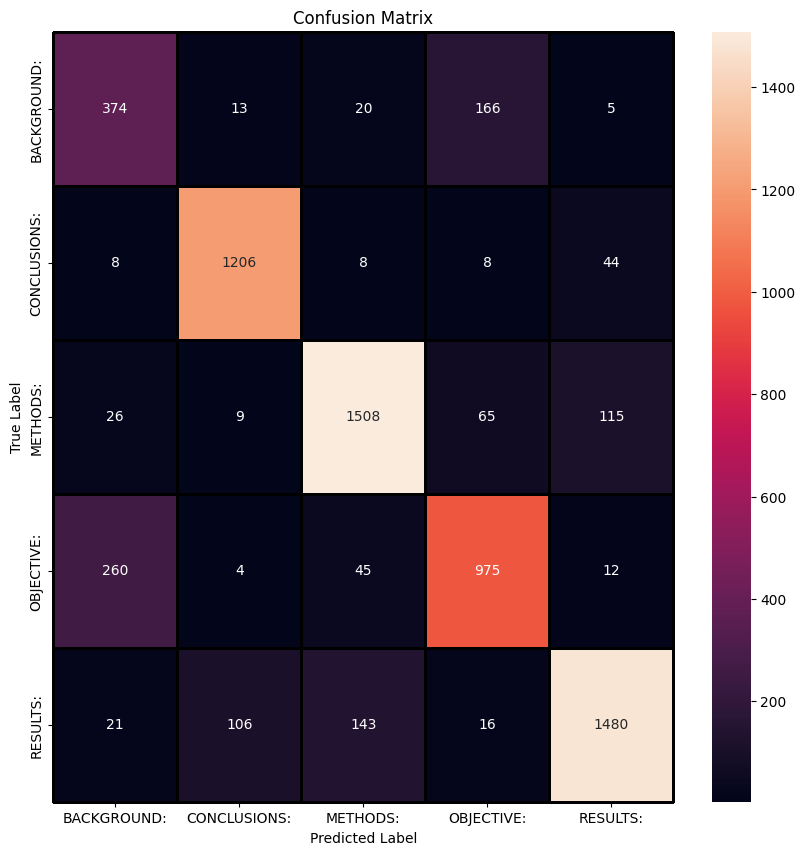

In [87]:
# View Confusion Matrix
plot_confusion_matrix(
    test_labels_encoded, 
    test_predictions, 
    figsize=(10, 10), 
    classes=list(class_names))